In [1]:
!pip install numpy-financial

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import numpy_financial as npf

# Config
pd.options.display.float_format = "{:.2f}".format #Table format

# Calculate Amortization

In [9]:
# Define amortization function
def amortization_schedule(interest_rate, terms, balance):
    df = pd.DataFrame(
        index = np.arange(1, terms + 1),
        columns = ['Payment', 'Principal', 'Interest'],
        dtype = np.float64
    )
    # Compute the payment against loan principal plus interest.
    '''The payment is computed by solving the equation::
    
     fv +
     pv*(1 + rate)**nper +
     pmt*(1 + rate*when)/rate*((1 + rate)**nper - 1) == 0
    
    or, when ``rate == 0``::
    
    fv + pv + pmt * nper == 0'''
    
    df['Payment'] = npf.pmt(interest_rate / 12, terms, balance)
    #Compute the payment against loan principal
    df['Principal'] = npf.ppmt(interest_rate / 12, df.index, terms, balance)
    #Compute the interest portion of a payment
    '''pmt = ppmt + ipmt'''
    df['Interest'] = npf.ipmt(interest_rate / 12, df.index, terms, balance)
    df['Ending_Balance'] = balance + df['Principal'].cumsum()
    return df

In [10]:
# Apply function
ats = amortization_schedule(0.036, 24, 500000)
ats

,Payment,Principal,Interest,Ending_Balance
1,-21623.55,-20123.55,-1500.00,479876.45
2,-21623.55,-20183.92,-1439.63,459692.52
3,-21623.55,-20244.48,-1379.08,439448.05
4,-21623.55,-20305.21,-1318.34,419142.84
5,-21623.55,-20366.12,-1257.43,398776.71
6,-21623.55,-20427.22,-1196.33,378349.49
7,-21623.55,-20488.51,-1135.05,357860.98
8,-21623.55,-20549.97,-1073.58,337311.01
9,-21623.55,-20611.62,-1011.93,316699.39
10,-21623.55,-20673.46,-950.10,296025.94


# Calculate Amortization with Inconsistent Schedule Term, Interest Rate and Installment

In [12]:
# Define next balance function
def balances(rate, payment, os):
    interest_amount = os * rate / 100 / 12
    next_balance = os + interest_amount - payment
    return round(next_balance, 2)

In [51]:
def amortization_inconsistent_term(rate, payment, os):
    amortization = []
    while os > 0:
        os = balances(rate, payment, os)
        amortization.append(os)
    df = pd.DataFrame(
        index = np.arange(1, len(amortization)),
        columns = ['Ending_balance'],
        dtype = np.float64
    )
    df['Ending_balance'] = amortization[:-1]
    return df
        

In [52]:
# Define parameters
rate = 3.6
payment = 15000
os = 500000
amortization_inconsistent_term(rate, payment, os)

,Ending_balance
1,486500.00
2,472959.50
3,459378.38
4,445756.52
5,432093.79
6,418390.07
7,404645.24
8,390859.18
9,377031.76
10,363162.86


# The Amortization Schedule of Hybird Loan with Truncate Option

In [50]:
def remaining_life(df):
    df['LimitTenor'] = round((df['LimitMaturity'] - df['AsOfDate']) / np.timedelta64(1, 'M'))
    df['AccountTenor'] = round((df['AccountMaturity'] - df['AsOfDate']) / np.timedelta64(1, 'M'))
    return(df)

In [53]:
# Define amortization function
def amortization_hybrid_loan(df, stage, tenor, amortization = []):
    # Get amortization parameters
    rate = df['EIR'].values[0]
    payment = df['Installment'].values[0]
    amount = df['Outstanding'].values[0]
    amortization = [amount] #Get outstanding at reporting date
    '''
    If outstanding less than payment, it means the reporting date is the last date.
    Therefore, the remaining outstanding will be used for ECL without amortization.
    '''
    if amount - payment <= 0:
        df['DiscountTime'] = 1
        return df
    else:
        if stage == 1 and tenor > 12:
            for _ in range(11):
                amount = balances(rate, payment, amount) #Stage 1 amortize for 12-months
                if amount <= 0:
                    continue #Remove negative payment at last outstanding
                amortization.append(amount)
            # Create new payment array
            newPayment = np.repeat(
                payment,
                len(amortization)
            )
            if len(amortization) < 12:
                newPayment[-1] = amortization[-1] #Last payment has to close outstanding
        else:
            for _ in range(tenor - 1):
                amount = balances(rate, payment, amount) #Stage 1 and stage 2 amortize for remaining life
                if amount <= 0:
                    continue #Remove negative payment at last outstanding
                amortization.append(amount)
            # Create new payment array
            newPayment = np.repeat(
                payment,
                len(amortization)
            )
            newPayment[-1] = amortization[-1] #Last payment has to close outstanding
        # To DataFrame
        scheduleTable = pd.DataFrame(
        np.repeat(
            df.values,
            len(amortization),
            axis = 0
        ),
        columns = df.columns
    )
        scheduleTable['Outstanding'] = amortization
        scheduleTable['Installment'] = newPayment #Assign new payment to close outstanding
        scheduleTable['DiscountTime'] = scheduleTable.index + 1
    return scheduleTable

# Data

In [56]:
data = pd.read_csv('ECLLimitData.csv',
                   dtype = {
                       'LimitID': str,
                       'AccountID': str
                   },
                   parse_dates = ['AsOfDate', 'LimitMaturity', 'AccountMaturity']
                  )

In [60]:
enhanced_data = remaining_life(data)
enhanced_data.head(3)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,nan,9.06,1,2025-12-31,2025-12-31,36.00,36.00
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,nan,7.34,1,2025-12-31,2025-06-30,36.00,30.00


# Term loan account, not closing before 12 months

In [62]:
sample_data = enhanced_data.query("AccountID == '611267004'")
case1 = amortization_hybrid_loan(sample_data, int(sample_data['Stage']), int(sample_data['AccountTenor']))
case1

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,1
1,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,157500.10,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,2
2,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,147919.80,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,3
3,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,138286.96,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,4
4,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,128601.30,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,5
5,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,118862.53,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,6
6,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,109070.36,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,7
7,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,99224.50,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,8
8,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,89324.65,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,9
9,2022-12-31 00:00:00,999999999999941,611267004,TL,574225.24,79370.52,10443.93,6.58,1,2025-12-31 00:00:00,2024-01-31 00:00:00,36.00,13.00,10


In [67]:
case1['DiscountTime']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
Name: DiscountTime, dtype: int64

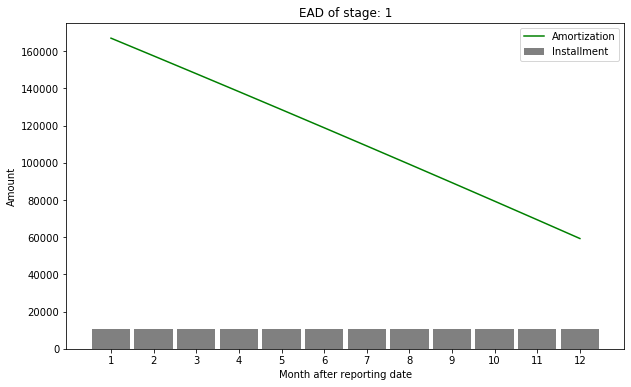

In [71]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(
    case1['DiscountTime'],
    case1['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case1['DiscountTime'],
    case1['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case1['DiscountTime'].min(), case1['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 1')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()

#  Term loan account, remaining tenor less than 12 months
 At the month 8 the installment will be full repaid for closing the loan.

In [73]:
case2 = enhanced_data.query("AccountID == '611267008'")
case2 = amortization_hybrid_loan(case2, int(case2['Stage']), int(case2['AccountTenor']))
case2
     

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,1
1,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,23652.65,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,2
2,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,22409.88,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,3
3,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,21161.66,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,4
4,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,19907.97,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,5
5,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,18648.78,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,6
6,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,17384.07,1346.45,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,7
7,2022-12-31 00:00:00,999999999999941,611267008,TL,574225.24,16113.82,16113.82,5.26,1,2025-12-31 00:00:00,2023-08-31 00:00:00,36.00,8.00,8


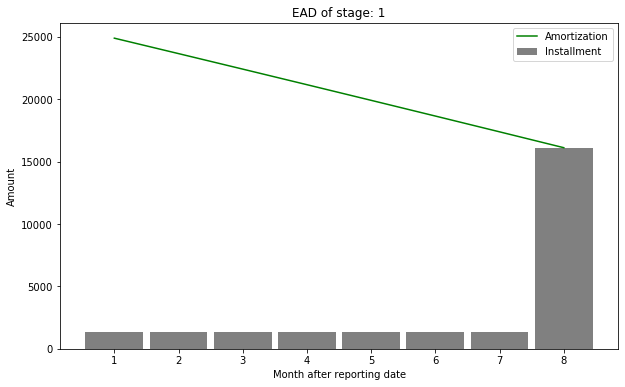

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(
    case2['DiscountTime'],
    case2['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case2['DiscountTime'],
    case2['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case2['DiscountTime'].min(), case2['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 1')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()

# Term loan account, remaining tenor more than 12 months, closing before 12 months
The amortization will be calculated until closing period.

In [75]:
case3 = enhanced_data.query("AccountID == '541047303'")
case3 = amortization_hybrid_loan(case3, int(case3['Stage']), int(case3['AccountTenor']))
case3
     

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999909,541047303,TL,420934.58,26601.08,8411.21,5.23,1,2027-09-30 00:00:00,2024-09-30 00:00:00,57.00,21.00,1
1,2022-12-31 00:00:00,999999999999909,541047303,TL,420934.58,18305.81,8411.21,5.23,1,2027-09-30 00:00:00,2024-09-30 00:00:00,57.00,21.00,2
2,2022-12-31 00:00:00,999999999999909,541047303,TL,420934.58,9974.38,8411.21,5.23,1,2027-09-30 00:00:00,2024-09-30 00:00:00,57.00,21.00,3
3,2022-12-31 00:00:00,999999999999909,541047303,TL,420934.58,1606.64,1606.64,5.23,1,2027-09-30 00:00:00,2024-09-30 00:00:00,57.00,21.00,4


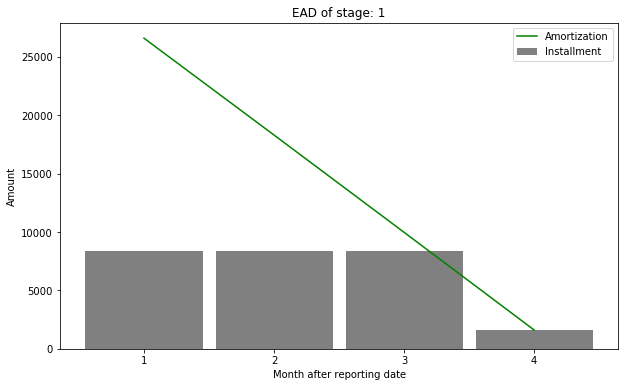

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 6))
plt.plot(
    case3['DiscountTime'],
    case3['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case3['DiscountTime'],
    case3['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case3['DiscountTime'].min(), case3['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 1')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()

#  Term loan account, remaining tenor 12, closing at 12 months
Outstanding will be amortized for 12 months.

If there is any outstanding left, the installment will be full repaid for closing the loan.

In [78]:
# Example
case4 = enhanced_data.query("AccountID == '611267007'")
case4 = amortization_hybrid_loan(case4, int(case4['Stage']), int(case4['AccountTenor']))
case4


,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,1
1,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,53184.84,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,2
2,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,49955.67,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,3
3,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,46712.42,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,4
4,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,43455.04,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,5
5,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,40183.46,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,6
6,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,36897.62,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,7
7,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,33597.46,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,8
8,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,30282.92,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,9
9,2022-12-31 00:00:00,999999999999941,611267007,TL,574225.24,26953.93,3460.97,5.23,1,2025-12-31 00:00:00,2023-12-31 00:00:00,36.00,12.00,10


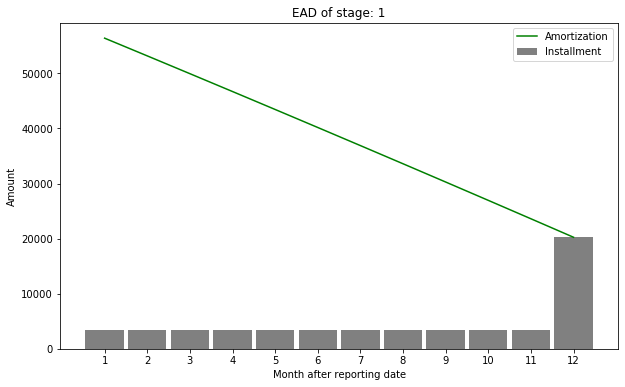

In [79]:
plt.figure(figsize = (10, 6))
plt.plot(
    case4['DiscountTime'],
    case4['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case4['DiscountTime'],
    case4['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case4['DiscountTime'].min(), case4['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 1')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()

# Term loan account, remaining tenor more than 12, closing before remaining tenor. 

The account has remaining tenor as 43 months hence, outstanding will be amortized for 43 months. However, if the outstanding becomes 0 before remaining tenor, outstanding will be amortized until that period.



In [81]:
case5 = enhanced_data.query("AccountID == '521028378'")
case5 = amortization_hybrid_loan(case5, int(case5['Stage']), int(case5['AccountTenor']))
case5

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,621959.86,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,1
1,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,594803.94,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,2
2,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,567540.98,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,3
3,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,540170.56,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,4
4,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,512692.25,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,5
5,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,485105.63,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,6
6,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,457410.27,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,7
7,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,429605.75,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,8
8,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,401691.63,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,9
9,2022-12-31 00:00:00,999999999999979,521028378,TL,743438.31,373667.48,29607.48,4.73,2,2027-06-30 00:00:00,2026-07-31 00:00:00,54.00,43.00,10


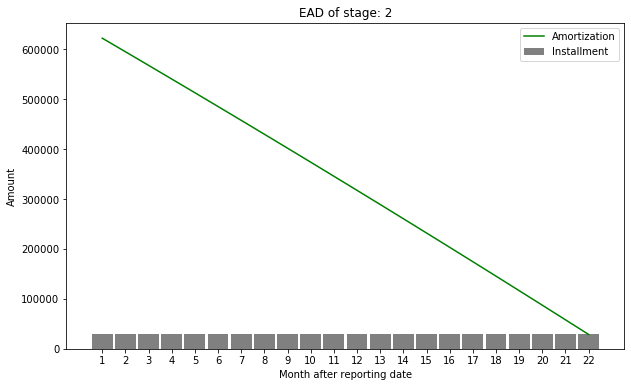

In [83]:
plt.figure(figsize = (10, 6))
plt.plot(
    case5['DiscountTime'],
    case5['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case5['DiscountTime'],
    case5['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case5['DiscountTime'].min(), case5['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 2')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()

# Term loan account, remaining tenor 48 months, closing before remaining tenor. 

The account has remaining tenor as 48 months hence, outstanding will be amortized for 48 months. However, if the outstanding becomes 0 before remaining tenor, outstanding will be amortized until that period.


In [84]:
case6 = enhanced_data.query("AccountID == '521028380'")
case6 = amortization_hybrid_loan(case6, int(case6['Stage']), int(case6['AccountTenor']))
case6

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999979,521028380,TL,743438.31,24676.52,7053.27,4.73,2,2027-06-30 00:00:00,2026-12-31 00:00:00,54.00,48.00,1
1,2022-12-31 00:00:00,999999999999979,521028380,TL,743438.31,17720.51,7053.27,4.73,2,2027-06-30 00:00:00,2026-12-31 00:00:00,54.00,48.00,2
2,2022-12-31 00:00:00,999999999999979,521028380,TL,743438.31,10737.09,7053.27,4.73,2,2027-06-30 00:00:00,2026-12-31 00:00:00,54.00,48.00,3
3,2022-12-31 00:00:00,999999999999979,521028380,TL,743438.31,3726.14,3726.14,4.73,2,2027-06-30 00:00:00,2026-12-31 00:00:00,54.00,48.00,4


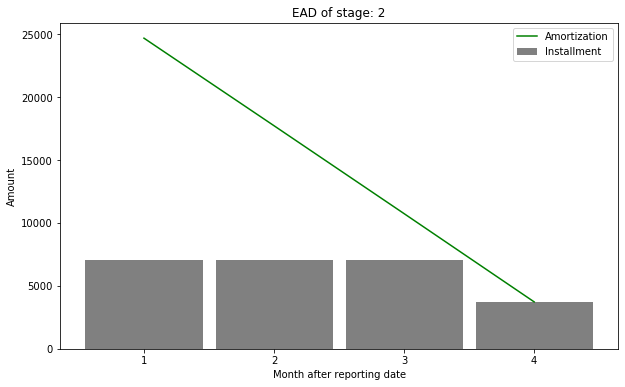

In [85]:
plt.figure(figsize = (10, 6))
plt.plot(
    case6['DiscountTime'],
    case6['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case6['DiscountTime'],
    case6['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case6['DiscountTime'].min(), case6['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 2')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()

# Revolving Product with Minimum Payment Rate

In [87]:
def add_min_payment(df, pay_rate):
    # Calculate minimum paymentdf
    df['Installment'] = np.where(
    df['Installment'].isnull(),
    pay_rate * df['Outstanding'], #Assume 2% payment of balance
    df['Installment']
    )
    return df


In [89]:
# Show table
enhanced_df = add_min_payment(enhanced_data, 0.02)
enhanced_df.head(3)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,376.65,7.34,1,2025-12-31,2025-06-30,36.00,30.00


#  Revolving product account, not closing before 12 months, remaining tenor as 36 months 

Outstanding will be amortized only 12 months.

In [90]:
case7 = enhanced_df.query("AccountID == '611267005'")
case7 = amortization_hybrid_loan(case7, int(case7['Stage']), int(case7['AccountTenor']))
case7

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,83661.58,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,1
1,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,82619.99,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,2
2,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,81570.54,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,3
3,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,80513.17,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,4
4,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,79447.81,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,5
5,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,78374.41,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,6
6,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,77292.91,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,7
7,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,76203.24,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,8
8,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,75105.34,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,9
9,2022-12-31 00:00:00,999999999999941,611267005,RP,574225.24,73999.15,1673.23,9.06,1,2025-12-31 00:00:00,2025-12-31 00:00:00,36.00,36.00,10


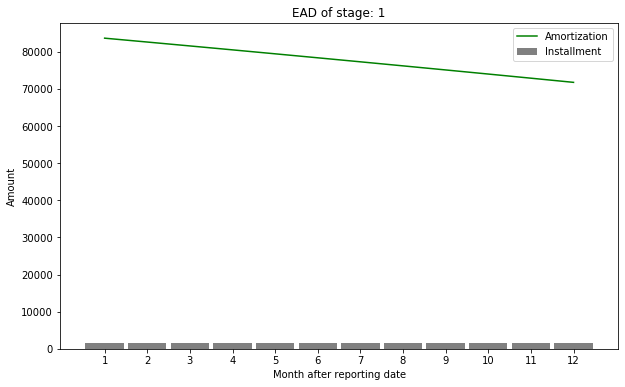

In [91]:
plt.figure(figsize = (10, 6))
plt.plot(
    case7['DiscountTime'],
    case7['Outstanding'],
    color = 'green',
    label = 'Amortization'
)
plt.bar(
    case7['DiscountTime'],
    case7['Installment'],
    color = 'gray',
    width = 0.9,
    label = 'Installment'
)
plt.xticks(
    range(case7['DiscountTime'].min(), case7['DiscountTime'].max() + 1, 1)
)
plt.title(f'EAD of stage: 1')
plt.xlabel('Month after reporting date')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 1)

plt.show()